In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wcukierski/enron-email-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\pc\.cache\kagglehub\datasets\wcukierski\enron-email-dataset\versions\2


In [19]:
import os
import re
import string
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Download necessary NLTK resources
nltk.download("stopwords")
nltk.download("punkt")

# List all files in the dataset directory
files = os.listdir(path)
print("Dataset Files:", files)

Dataset Files: ['emails.csv']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv(os.path.join(path, "emails.csv"))
# Map Threat column to numerical (Yes -> 1, No -> 0)
df["Threat"] = np.random.choice(["Yes", "No"], size=len(df), p=[0.5, 0.5])
df["Threat"] = df["Threat"].map({"Yes": 1, "No": 0})
# Display first few rows
print(df.head(5))


                       file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                             message  Threat  
0  Message-ID: <18782981.1075855378110.JavaMail.e...       1  
1  Message-ID: <15464986.1075855378456.JavaMail.e...       1  
2  Message-ID: <24216240.1075855687451.JavaMail.e...       1  
3  Message-ID: <13505866.1075863688222.JavaMail.e...       1  
4  Message-ID: <30922949.1075863688243.JavaMail.e...       1  


In [6]:
print("Dataset Shape:", df.shape)

print(df.info())  # Overview of columns and data types
print(df.describe())  # Summary statistics
print(df.isnull().sum())  # Count of missing values

Dataset Shape: (517401, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
 2   Threat   517401 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 11.8+ MB
None
              Threat
count  517401.000000
mean        0.499698
std         0.500000
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
file       0
message    0
Threat     0
dtype: int64


In [7]:
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
# Function to preprocess text
def preprocess_text(text):
    if not isinstance(text, str):  # Handle missing or non-string values
        return ""
    
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = " ".join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
df_sample = df.sample(n=40000, random_state=42)  # Use 40,000 samples

In [33]:
# Apply text preprocessing
df_sample["file"] = df_sample["file"].astype(str)
df_sample["clean_file"] = df_sample["file"].apply(preprocess_text)

df_sample["message"] = df_sample["message"].astype(str)
df_sample["clean_message"] = df_sample["message"].apply(preprocess_text)

In [34]:
vectorizer = TfidfVectorizer(max_features=1000)
X_file = vectorizer.fit_transform(df_sample["clean_file"])

# Convert to DataFrame with actual words as column names
X_file_df = pd.DataFrame(X_file.toarray(), columns=vectorizer.get_feature_names_out())

X_file_df = X_file_df.reset_index(drop=True)

X_message = vectorizer.fit_transform(df_sample["clean_message"])

# Convert to DataFrame with actual words as column names
X_message_df = pd.DataFrame(X_message.toarray(), columns=vectorizer.get_feature_names_out())

X_message_df = X_message_df.reset_index(drop=True)


X = pd.concat([X_file_df, X_message_df], axis=1)
y = df_sample["Threat"]

In [15]:
print(len(X), len(y))  # They should be the same

20000 20000


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Function to train model and return accuracy
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model =  RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Baseline Model (Raw Data)
accuracy_baseline = train_and_evaluate(X_train, X_test, y_train, y_test)
print("Baseline Model Accuracy (Raw Data):", accuracy_baseline)

Baseline Model Accuracy (Raw Data): 0.51425


In [37]:
# Function to train model and return accuracy
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model =  RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# encoded or vecotrized data
accuracy_encoded = train_and_evaluate(X_train, X_test, y_train, y_test)
print("Baseline Model Accuracy (Raw Data):", accuracy_encoded)

Baseline Model Accuracy (Raw Data): 0.499625


In [38]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
accuracy_standardized = train_and_evaluate(X_train_scaled, X_test_scaled, y_train, y_test)
print("Standardized Model Accuracy:", accuracy_standardized)

Standardized Model Accuracy: 0.5045


In [39]:
# Feature Selection (Select best 3000 features)
selector = SelectKBest(chi2, k=3000)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
accuracy_feature_selection = train_and_evaluate(X_train_selected, X_test_selected, y_train, y_test)
print("Feature Selection Model Accuracy:", accuracy_feature_selection)

C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=3000 is greater than n_features=2000. All the features will be returned.
  warnings.warn(


Feature Selection Model Accuracy: 0.499


In [25]:
# SMOTE (Handle Imbalanced Data)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
accuracy_smote = train_and_evaluate(X_train_smote, X_test, y_train_smote, y_test)

print("SMOTE Model Accuracy:", accuracy_smote)

SMOTE Model Accuracy: 0.50275


In [40]:
# PCA (Reduce to 300 components)
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
accuracy_pca = train_and_evaluate(X_train_pca, X_test_pca, y_train, y_test)
print("PCA Model Accuracy:", accuracy_pca) 

PCA Model Accuracy: 0.503625


dict_values([0.51425, 0.5045, 0.50275, 0.499, 0.503625, 0.499625])


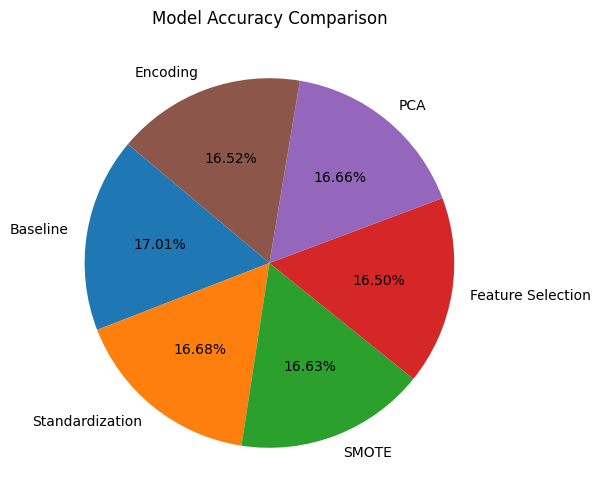

In [41]:
# Store Accuracy Scores
accuracy_percentages = {
    "Baseline": accuracy_baseline ,
    "Standardization": accuracy_standardized,
    "SMOTE": accuracy_smote ,
    "Feature Selection": accuracy_feature_selection ,
    "PCA": accuracy_pca ,
    "Encoding": accuracy_encoded
}
print(accuracy_percentages.values())
# Pie chart
# Divide each value by the number of categories to make them sum to 100%
num_categories = len(accuracy_percentages)
accuracy_percentages = {k: v / num_categories for k, v in accuracy_percentages.items()}

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(accuracy_percentages.values(), labels=accuracy_percentages.keys(), autopct='%1.2f%%', startangle=140)
plt.title("Model Accuracy Comparison")
plt.show()

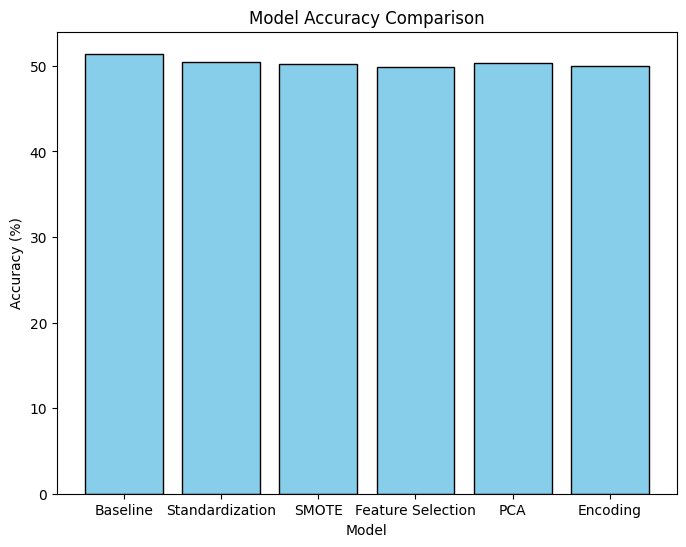

In [42]:
accuracies = [
    ("Baseline", accuracy_baseline * 100),
    ("Standardization", accuracy_standardized * 100),
    ("SMOTE", accuracy_smote * 100),
    ("Feature Selection", accuracy_feature_selection * 100),
    ("PCA",accuracy_pca * 100),
    ("Encoding",accuracy_encoded * 100)
]

# Extract model names and accuracy values
model_names = [model[0] for model in accuracies]
accuracy_values = [model[1] for model in accuracies]

# Create the histogram
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracy_values, color='skyblue', edgecolor='black')

# Add title and labels
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")

# Show the plot
plt.show()

In [43]:
accuracies = [
    ("Baseline", accuracy_baseline * 100),
    ("Standardization",accuracy_standardized * 100),
   
    ("SMOTE", accuracy_smote * 100),
    ("Feature Selection", accuracy_feature_selection * 100),
    ("PCA", accuracy_pca* 100),
    ("Encoding",accuracy_encoded * 100)
]

# Convert the list into a DataFrame
accuracy_df = pd.DataFrame(accuracies, columns=["Model", "Accuracy (%)"])

# Display the table
print(accuracy_df)

               Model  Accuracy (%)
0           Baseline       51.4250
1    Standardization       50.4500
2              SMOTE       50.2750
3  Feature Selection       49.9000
4                PCA       50.3625
5           Encoding       49.9625
